### PCA on SVI 2018 data for Multiple regions

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings


# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import the dataset

In [71]:
washingtonDcSviRaw = gpd.read_file('./washington dc/data/processed data/SVI2018 DC counties with death rate HepVu/SVI2018_DC_counties_with_death_rate_HepVu.shp')

In [72]:
tnSviRaw = gpd.read_file('./tennessee/data/processed data/SVI2018 TN counties with death rate HepVu/SVI2018_TN_counties_with_death_rate_HepVu.shp')

In [73]:
WySviRaw = gpd.read_file('./wyoming/data/processed data/SVI2018 WY counties with death rate HepVu/SVI2018_WY_counties_with_death_rate_HepVu.shp')

##### Rename columns

In [74]:
# Rename selected columns for better readability
washingtonDcSviRaw.rename(columns={'ST':'State','STCNTY':'CountyCode','COUNTY':'County','EP_POV':'Poverty','EP_UNEMP':'Unemployment','EP_PCI':'Income','EP_NOHSDP':'NoHighSchoolDiploma','EP_UNINSUR':'NoHealthInsurance','EP_AGE65':'Age>65','EP_AGE17':'Age<17','EP_DISABL':'Disability','EP_SNGPNT':'SingleParentHousehold','EP_LIMENG':'LimitedEnglish','EP_MINRTY':'Minority','EP_MUNIT':'HoustingUnits>10','EP_MOBILE':'MobileHomes','EP_CROWD':'Overcrowding','EP_NOVEH':'NoVehicle','EP_GROUPQ':'GroupQuarters','NOD_Rate':'DeathRate'}, inplace=True)

tnSviRaw.rename(columns={'ST':'State','STCNTY':'CountyCode','COUNTY':'County','EP_POV':'Poverty','EP_UNEMP':'Unemployment','EP_PCI':'Income','EP_NOHSDP':'NoHighSchoolDiploma','EP_UNINSUR':'NoHealthInsurance','EP_AGE65':'Age>65','EP_AGE17':'Age<17','EP_DISABL':'Disability','EP_SNGPNT':'SingleParentHousehold','EP_LIMENG':'LimitedEnglish','EP_MINRTY':'Minority','EP_MUNIT':'HoustingUnits>10','EP_MOBILE':'MobileHomes','EP_CROWD':'Overcrowding','EP_NOVEH':'NoVehicle','EP_GROUPQ':'GroupQuarters','NOD_Rate':'DeathRate'}, inplace=True)

WySviRaw.rename(columns={'ST':'State','STCNTY':'CountyCode','COUNTY':'County','EP_POV':'Poverty','EP_UNEMP':'Unemployment','EP_PCI':'Income','EP_NOHSDP':'NoHighSchoolDiploma','EP_UNINSUR':'NoHealthInsurance','EP_AGE65':'Age>65','EP_AGE17':'Age<17','EP_DISABL':'Disability','EP_SNGPNT':'SingleParentHousehold','EP_LIMENG':'LimitedEnglish','EP_MINRTY':'Minority','EP_MUNIT':'HoustingUnits>10','EP_MOBILE':'MobileHomes','EP_CROWD':'Overcrowding','EP_NOVEH':'NoVehicle','EP_GROUPQ':'GroupQuarters','NOD_Rate':'DeathRate'}, inplace=True)


##### Filtering the raw variables with overdose death rate

Selected variables are slightly different thatn SVI 2020 (2 variables) - EP_PCI. EP_POV

In [75]:
selectedVariables = ['Poverty','Unemployment','Income','NoHighSchoolDiploma','NoHealthInsurance','Age>65','Age<17','Disability','SingleParentHousehold','LimitedEnglish','Minority','HoustingUnits>10','MobileHomes','Overcrowding','NoVehicle','GroupQuarters','DeathRate']

In [76]:
selectedVariablesWithoutY = ['Poverty','Unemployment','Income','NoHighSchoolDiploma','NoHealthInsurance','Age>65','Age<17','Disability','SingleParentHousehold','LimitedEnglish','Minority','HoustingUnits>10','MobileHomes','Overcrowding','NoVehicle','GroupQuarters']

In [77]:
# Filtering the data for DC
metroSviMultipleVariablesDf = washingtonDcSviRaw[selectedVariables]

In [78]:
# Filtering the data for TN
tnSviMultipleVariablesDf = tnSviRaw[selectedVariables]

In [79]:
# Filtering the data for WY
wySviMultipleVariablesDf = WySviRaw[selectedVariables]

#### Applying PCA

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [81]:
#define predictor and response variables
X_Dc = metroSviMultipleVariablesDf.drop('DeathRate', axis=1)
y_Dc = metroSviMultipleVariablesDf['DeathRate']

In [82]:
#define predictor and response variables
X_Tn = tnSviMultipleVariablesDf.drop('DeathRate', axis=1)
y_Tn = tnSviMultipleVariablesDf['DeathRate']

In [83]:
#define predictor and response variables
X_Wy = wySviMultipleVariablesDf.drop('DeathRate', axis=1)
y_Wy = wySviMultipleVariablesDf['DeathRate']

In [84]:
#define scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

The fit method is used to compute the mean and standard deviation of the input data, which will be used for later scaling. It is essentially the process of computing the parameters needed for the transformation. 

When you call fit, the StandardScaler calculates the mean and standard deviation of each feature in the training data. These parameters are stored in the mean_ and scale_ attributes of the scaler object

The fit_transform method not only computes the mean and standard deviation but also applies the transformation to the data. It centers and scales the data based on the computed mean and standard deviation.

It returns the transformed data, and the original data is not modified. The fit_transform method is often used when you have a training dataset and you want to both compute the scaling parameters and apply the transformation to the data in a single step.

In [85]:
# scaled_X
scaled_X_Dc = pd.DataFrame(scaler.fit_transform(X_Dc), columns=X_Dc.columns)
scaled_X_Tn = pd.DataFrame(scaler.fit_transform(X_Tn), columns=X_Tn.columns)
scaled_X_Wy = pd.DataFrame(scaler.fit_transform(X_Wy), columns=X_Wy.columns)

In [86]:
from sklearn.decomposition import PCA

#define PCA model as many components
pca_Dc = PCA(n_components=16)

#define PCA model as many components
pca_Tn = PCA(n_components=16)

#define PCA model as many components
pca_Wy = PCA(n_components=16)

In [87]:
#fit PCA model to data
pca_Dc_transformed_data = pca_Dc.fit_transform(scaled_X_Dc)

#fit PCA model to data
pca_Tn_transformed_data = pca_Tn.fit_transform(scaled_X_Tn)

#fit PCA model to data
pca_Wy_transformed_data = pca_Wy.fit_transform(scaled_X_Wy)

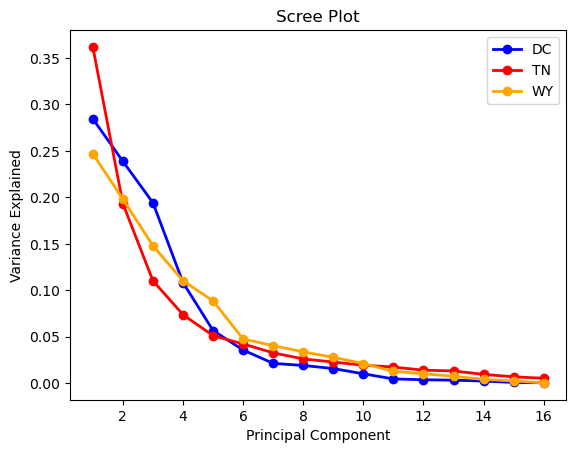

In [88]:
PC_values = np.arange(pca_Dc.n_components_) + 1
plt.plot(PC_values, pca_Dc.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.plot(PC_values, pca_Tn.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.plot(PC_values, pca_Wy.explained_variance_ratio_, 'o-', linewidth=2, color='orange')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend(['DC', 'TN','WY'], loc='best')
plt.show()

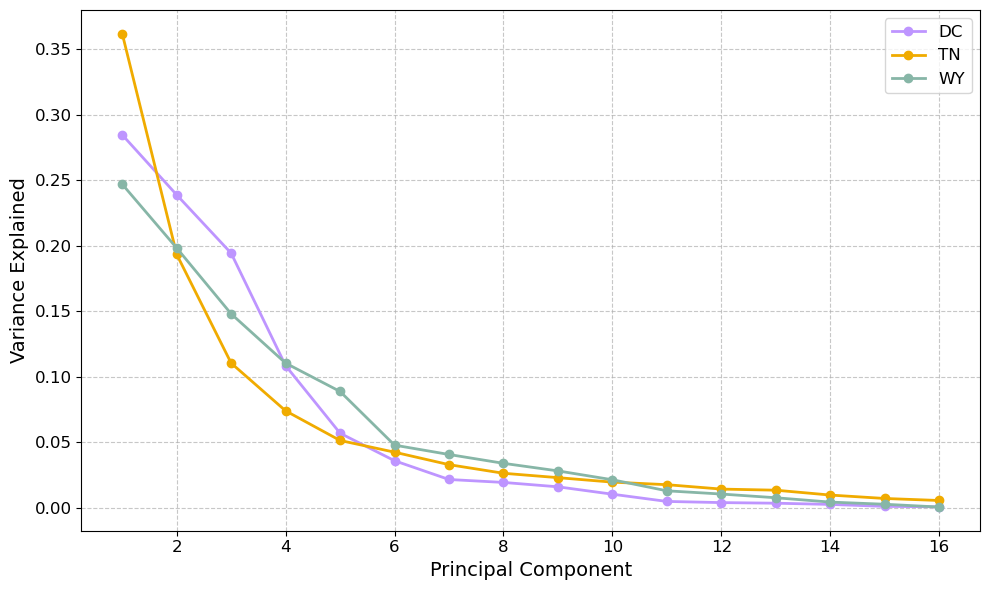

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data
PC_values = np.arange(pca_Dc.n_components_) + 1
explained_variance_ratios = [pca_Dc.explained_variance_ratio_,
                             pca_Tn.explained_variance_ratio_,
                             pca_Wy.explained_variance_ratio_]
colors = ['#be95ff', '#F0AB00', '#87B6A7']
labels = ['DC', 'TN', 'WY']

# Plot
plt.figure(figsize=(10, 6))  # Increase figure size
for i, evr in enumerate(explained_variance_ratios):
    plt.plot(PC_values, evr, marker='o', linestyle='-', linewidth=2, color=colors[i])

#plt.title('Scree Plot', fontsize=16)  # Title with larger font size
plt.xlabel('Principal Component', fontsize=14)  # Label with larger font size
plt.ylabel('Variance Explained', fontsize=14)  # Label with larger font size
plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)  # Increase tick font size
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines
plt.legend(labels, loc='upper right', fontsize=12)  # Legend with larger font size
plt.tight_layout()  # Adjust layout
plt.show()

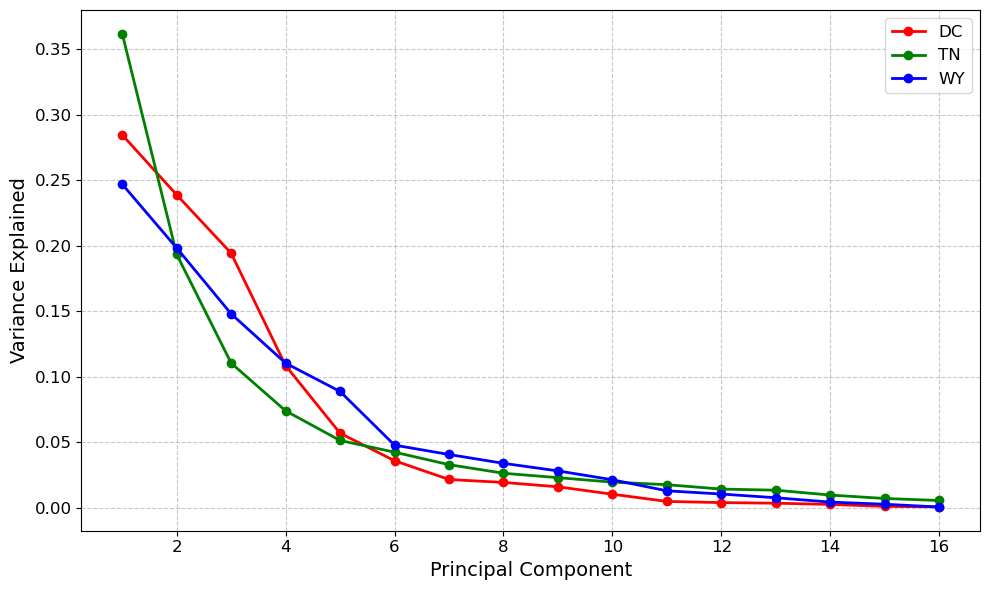

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data
PC_values = np.arange(pca_Dc.n_components_) + 1
explained_variance_ratios = [pca_Dc.explained_variance_ratio_,
                             pca_Tn.explained_variance_ratio_,
                             pca_Wy.explained_variance_ratio_]
colors = ['r', 'g', 'b']
labels = ['DC', 'TN', 'WY']

# Plot
plt.figure(figsize=(10, 6))  # Increase figure size
for i, evr in enumerate(explained_variance_ratios):
    plt.plot(PC_values, evr, marker='o', linestyle='-', linewidth=2, color=colors[i])

#plt.title('Scree Plot', fontsize=16)  # Title with larger font size
plt.xlabel('Principal Component', fontsize=14)  # Label with larger font size
plt.ylabel('Variance Explained', fontsize=14)  # Label with larger font size
plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)  # Increase tick font size
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines
plt.legend(labels, loc='upper right', fontsize=12)  # Legend with larger font size
plt.tight_layout()  # Adjust layout
plt.show()

In [91]:
# Check how much variance is explained by each principal components as a percentage
pca_Dc.explained_variance_ratio_*100

array([28.4509114 , 23.86572287, 19.41395704, 10.82994822,  5.67163884,
        3.57162945,  2.13881062,  1.91552005,  1.58031335,  1.01641731,
        0.46457734,  0.37566308,  0.32899594,  0.23674773,  0.08640242,
        0.05274432])

In [92]:
# Check how much variance is explained by each principal components as a percentage
pca_Tn.explained_variance_ratio_*100

array([36.17576763, 19.32418567, 11.02230149,  7.37921856,  5.11883832,
        4.22416931,  3.27208187,  2.61449297,  2.27977462,  1.93811427,
        1.74317315,  1.40714039,  1.3226357 ,  0.9512686 ,  0.69076136,
        0.53607607])

In [93]:
# Check how much variance is explained by each principal components as a percentage
pca_Wy.explained_variance_ratio_*100

array([24.68061543, 19.80976797, 14.78431069, 11.02183165,  8.85833319,
        4.76136324,  4.04763584,  3.37351002,  2.79526641,  2.11891787,
        1.2753676 ,  1.02890123,  0.74524695,  0.41371025,  0.2499988 ,
        0.03522287])

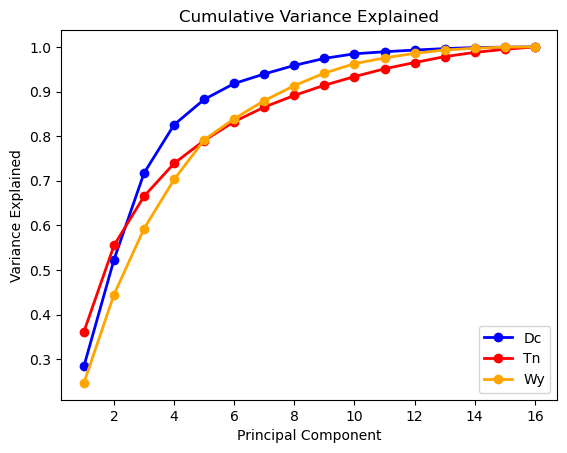

In [94]:
# plot cumulative variance explained
plt.plot(PC_values, np.cumsum(pca_Dc.explained_variance_ratio_), 'bo-', linewidth=2, label='Dc')
plt.plot(PC_values, np.cumsum(pca_Tn.explained_variance_ratio_), 'ro-', linewidth=2, label='Tn')
plt.plot(PC_values, np.cumsum(pca_Wy.explained_variance_ratio_), 'o-',color='orange', linewidth=2, label='Wy')


plt.title('Cumulative Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend(loc='lower right')
plt.show()

##### Now we explore the features using PCA 

In [95]:
scaled_pca2_Dc = PCA(n_components=16).fit(scaled_X_Dc)
X_std_transformed_Dc = scaled_pca2_Dc.transform(scaled_X_Dc)

In [96]:
scaled_pca2_Tn = PCA(n_components=16).fit(scaled_X_Tn)
X_std_transformed2_Tn = scaled_pca2_Tn.transform(scaled_X_Tn)

In [97]:
scaled_pca2_Wy = PCA(n_components=16).fit(scaled_X_Wy)
X_std_transformed2_Wy = scaled_pca2_Wy.transform(scaled_X_Wy)

In [98]:
first_pca_component = pd.DataFrame(
    scaled_pca2_Dc.components_[0], index=X_Dc.columns, columns=["DC"]
)

In [99]:
first_pca_component["TN"] = scaled_pca2_Tn.components_[0]

In [100]:
first_pca_component["WY"] = scaled_pca2_Wy.components_[0]

In [101]:
colors = ['#be95ff', '#F0AB00', '#87B6A7']
labels = ['DC', 'TN', 'WY']

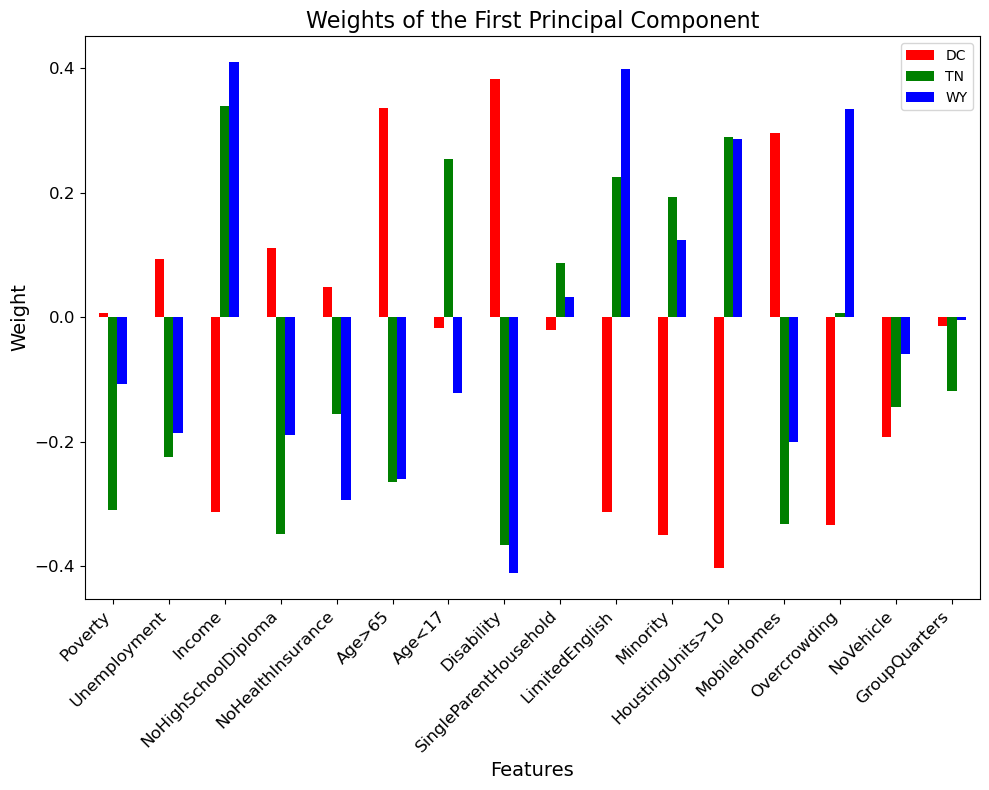

In [102]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size
first_pca_component.plot.bar(ax=ax, title="Weights of the First Principal Component", color=['r', 'g', 'b'])

# Set labels and title
ax.set_xlabel("Features", fontsize=14)  # Label with larger font size
ax.set_ylabel("Weight", fontsize=14)  # Label with larger font size
ax.set_title("Weights of the First Principal Component", fontsize=16)  # Title with larger font size
plt.xticks(fontsize=12, rotation=45, ha='right')  # Increase tick font size and rotate x-axis labels for better readability
plt.yticks(fontsize=12)  # Increase tick font size
plt.tight_layout()  # Adjust layout
plt.show()

In [29]:
first_pca_component

,DC,TN,WY
EP_POV,0.006649,-0.310329,-0.107007
EP_UNEMP,0.092955,-0.225084,-0.185430
EP_PCI,-0.312924,0.339002,0.409862
EP_NOHSDP,0.111398,-0.348057,-0.189677
EP_UNINSUR,0.047749,-0.156272,-0.293041
EP_AGE65,0.335204,-0.264101,-0.259543
EP_AGE17,-0.017385,0.253264,-0.121924
EP_DISABL,0.382119,-0.366570,-0.411266
EP_SNGPNT,-0.021320,0.087204,0.031639
EP_LIMENG,-0.313775,0.225543,0.398824


In [31]:
first_pca_component['WY']

EP_POV       -0.107007
EP_UNEMP     -0.185430
EP_PCI        0.409862
EP_NOHSDP    -0.189677
EP_UNINSUR   -0.293041
EP_AGE65     -0.259543
EP_AGE17     -0.121924
EP_DISABL    -0.411266
EP_SNGPNT     0.031639
EP_LIMENG     0.398824
EP_MINRTY     0.123946
EP_MUNIT      0.286375
EP_MOBILE    -0.201312
EP_CROWD      0.333870
EP_NOVEH     -0.059272
EP_GROUPQ    -0.004170
Name: WY, dtype: float64

In [32]:
# sort first_pca_component['WY'] abs values without editing the original dataframe
first_pca_component['WY'].abs().sort_values(ascending=False)


EP_DISABL     0.411266
EP_PCI        0.409862
EP_LIMENG     0.398824
EP_CROWD      0.333870
EP_UNINSUR    0.293041
EP_MUNIT      0.286375
EP_AGE65      0.259543
EP_MOBILE     0.201312
EP_NOHSDP     0.189677
EP_UNEMP      0.185430
EP_MINRTY     0.123946
EP_AGE17      0.121924
EP_POV        0.107007
EP_NOVEH      0.059272
EP_SNGPNT     0.031639
EP_GROUPQ     0.004170
Name: WY, dtype: float64

In [30]:
# Initialize a dictionary to store the indices of the top 5 absolute values for each column
top_indices = {}

# Iterate over each column in the DataFrame
for col in first_pca_component.columns:
    # Sort the absolute values of the column and get the indices of the top 5 values
    top_indices[col] = first_pca_component[col].abs().nlargest(5).index.tolist()

print("Top 5 indices for each column (ignoring negatives):")
print(top_indices)

Top 5 indices for each column (ignoring negatives):
{'DC': ['EP_MUNIT', 'EP_DISABL', 'EP_MINRTY', 'EP_AGE65', 'EP_CROWD'], 'TN': ['EP_DISABL', 'EP_NOHSDP', 'EP_PCI', 'EP_MOBILE', 'EP_POV'], 'WY': ['EP_DISABL', 'EP_PCI', 'EP_LIMENG', 'EP_CROWD', 'EP_UNINSUR']}
